In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [31]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset

from counterfactuals.optimizers.approach_gen_disc import ApproachGenDisc
from counterfactuals.optimizers.approach_three import ApproachThree

from counterfactuals.utils import plot_loss_space, plot_model_distribution

In [21]:
dataset = MoonsDataset(file_path="../data/origin/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)

In [22]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
cf = ApproachThree(model=flow)

In [23]:
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=100,
    verbose=True
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   1%|          | 1/100 [00:00<01:11,  1.38it/s]

Epoch 0, Train: 2.977910612052653, test: 1.5746332361147954


Epochs:  11%|█         | 11/100 [00:07<00:59,  1.49it/s]

Epoch 10, Train: 0.443874000922426, test: 0.42115192803052753


Epochs:  21%|██        | 21/100 [00:14<00:52,  1.50it/s]

Epoch 20, Train: 0.39644143804585263, test: 0.3653616171616774


Epochs:  31%|███       | 31/100 [00:20<00:45,  1.51it/s]

Epoch 30, Train: 0.38088667960393996, test: 0.4016574231477884


Epochs:  41%|████      | 41/100 [00:27<00:39,  1.51it/s]

Epoch 40, Train: 0.3704911071758766, test: 0.378227914755161


Epochs:  51%|█████     | 51/100 [00:34<00:32,  1.51it/s]

Epoch 50, Train: 0.3822224201449068, test: 0.3772567602304312


Epochs:  61%|██████    | 61/100 [00:40<00:25,  1.51it/s]

Epoch 60, Train: 0.36339353828074095, test: 0.35204973129125744


Epochs:  71%|███████   | 71/100 [00:47<00:19,  1.50it/s]

Epoch 70, Train: 0.3687240771013937, test: 0.34164970081586105


Epochs:  81%|████████  | 81/100 [00:54<00:12,  1.50it/s]

Epoch 80, Train: 0.36430016871203075, test: 0.3478919342160225


Epochs:  91%|█████████ | 91/100 [01:00<00:05,  1.51it/s]

Epoch 90, Train: 0.3625943687184032, test: 0.3474273601403603


Epochs: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


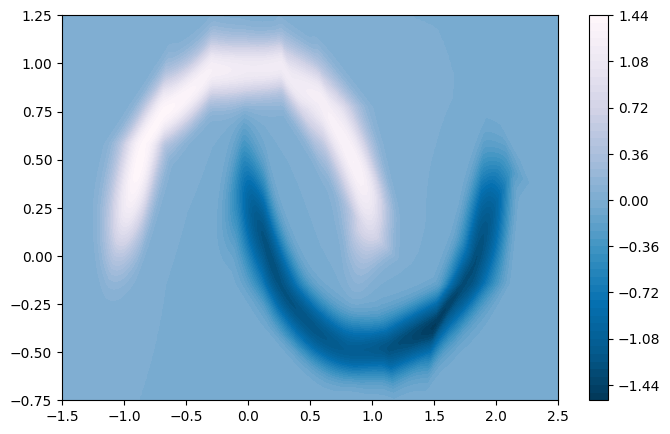

In [38]:
plot_model_distribution(cf.model)

tensor([0.4210], grad_fn=<AddBackward0>) 0.4210498631000519 0.0 0.0
tensor(-1.1143)


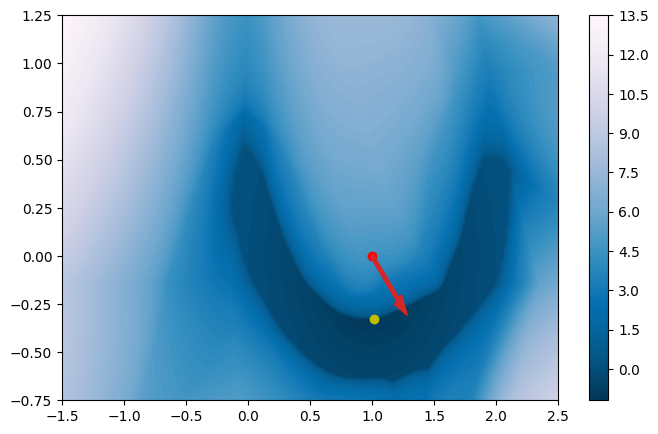

tensor([0.4051], grad_fn=<AddBackward0>) 0.40512704849243164 0.0 0.0
tensor(-1.1143)


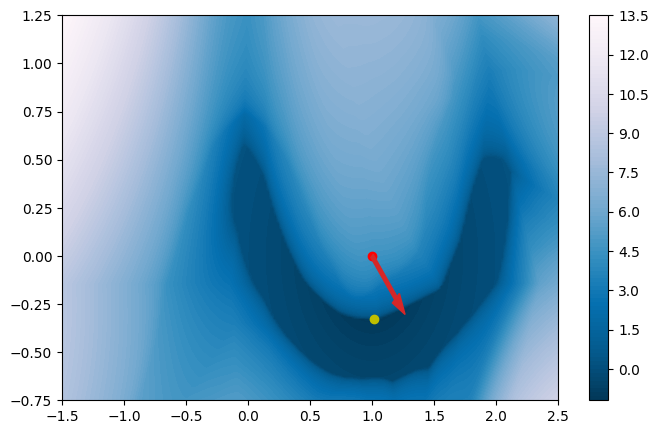

tensor([0.3846], grad_fn=<AddBackward0>) 0.38456016778945923 0.0 0.0
tensor(-1.1143)


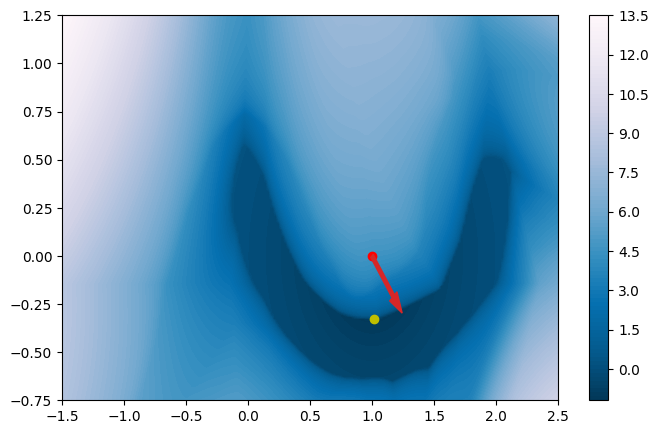

tensor([0.3608], grad_fn=<AddBackward0>) 0.36075958609580994 0.0 0.0
tensor(-1.1143)


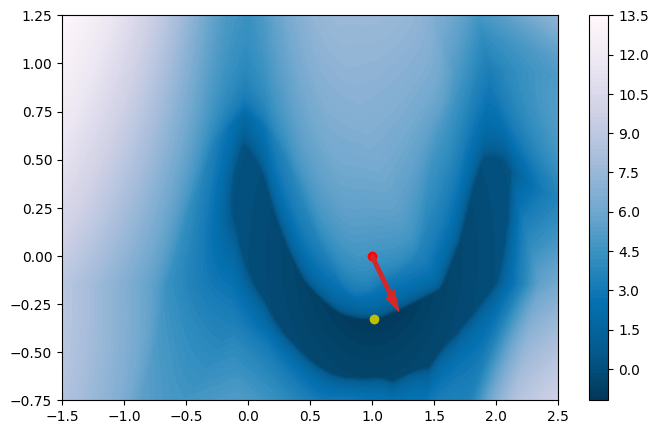

tensor([0.3500], grad_fn=<AddBackward0>) 0.3499740660190582 0.0 0.0
tensor(-1.1143)


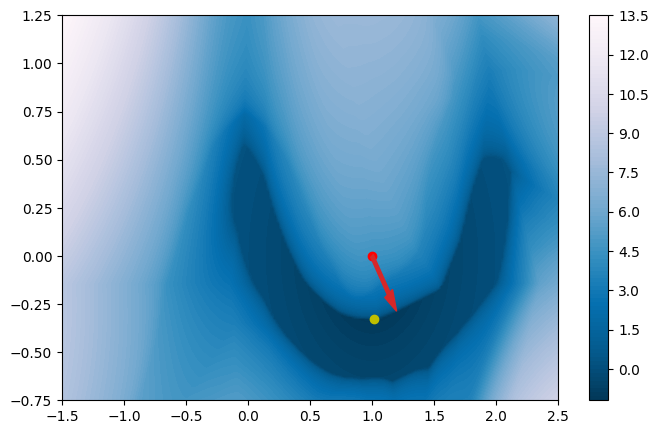

tensor([0.3548], grad_fn=<AddBackward0>) 0.35478997230529785 0.0 0.0
tensor(-1.1143)


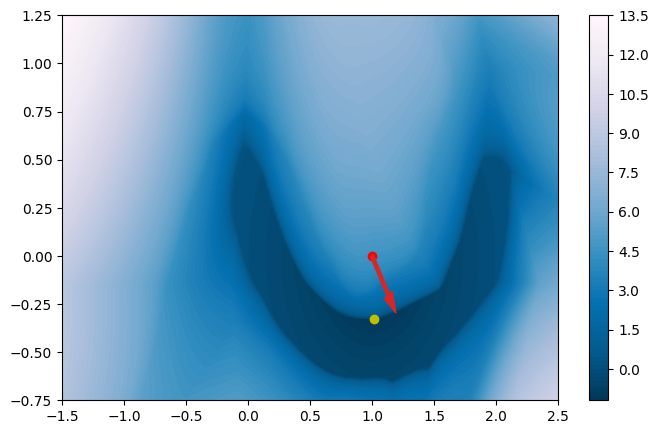

tensor([0.3423], grad_fn=<AddBackward0>) 0.3422945737838745 0.0 0.0
tensor(-1.1143)


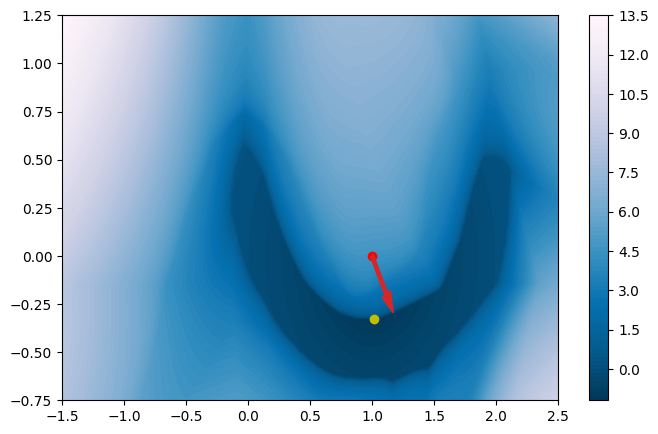

tensor([0.3452], grad_fn=<AddBackward0>) 0.34519878029823303 0.0 0.0
tensor(-1.1143)


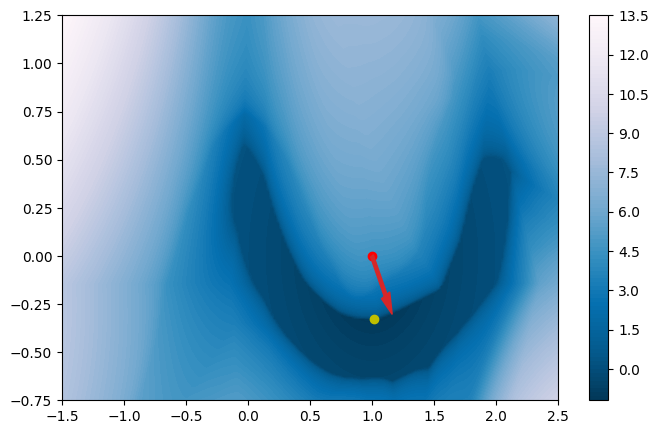

tensor([0.3436], grad_fn=<AddBackward0>) 0.3435944616794586 0.0 0.0
tensor(-1.1143)


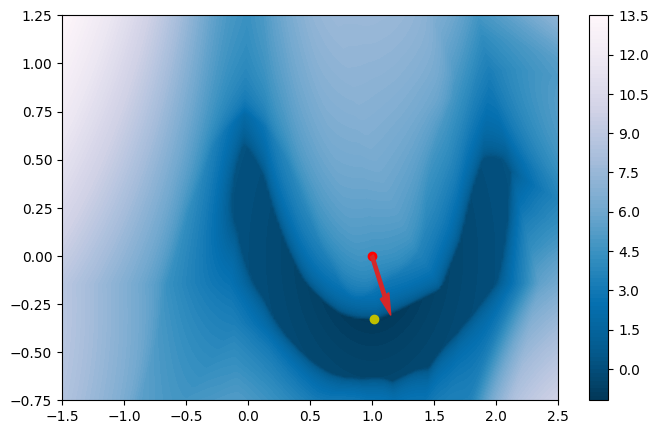

tensor([0.3375], grad_fn=<AddBackward0>) 0.33750301599502563 0.0 0.0
tensor(-1.1143)


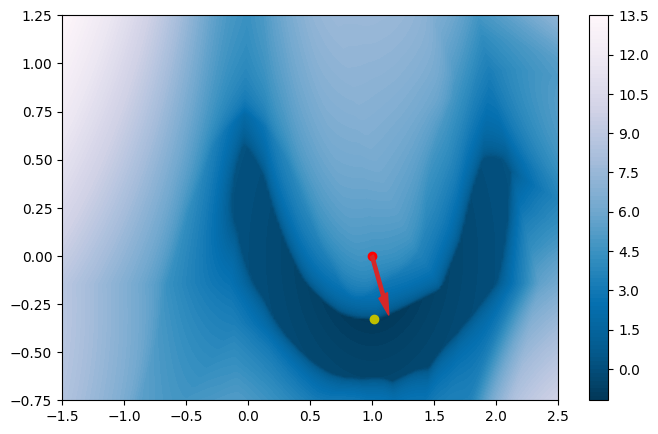

tensor([0.3427], grad_fn=<AddBackward0>) 0.34273168444633484 0.0 0.0
tensor(-1.1143)


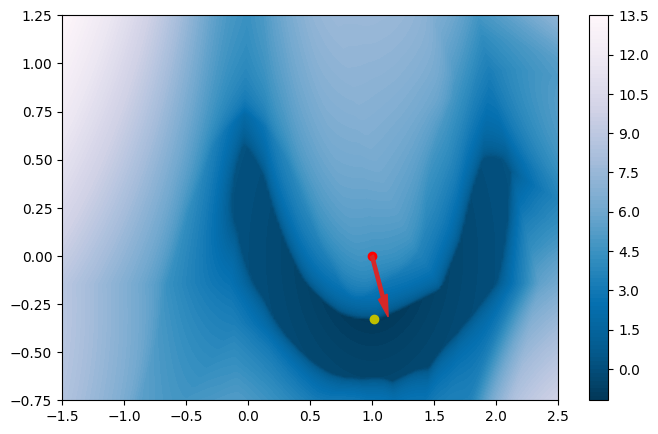

tensor([0.3318], grad_fn=<AddBackward0>) 0.3317694365978241 0.0 0.0
tensor(-1.1143)


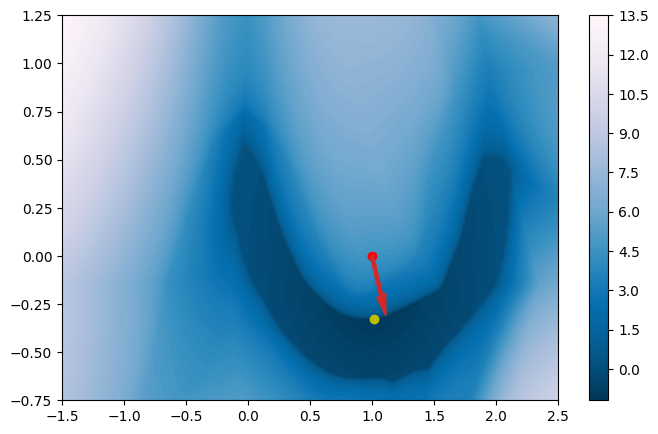

tensor([0.3402], grad_fn=<AddBackward0>) 0.3401966989040375 0.0 0.0
tensor(-1.1143)


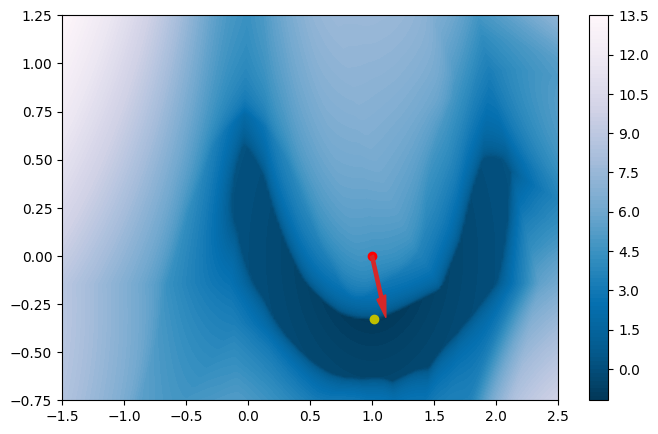

tensor([0.3358], grad_fn=<AddBackward0>) 0.33583611249923706 0.0 0.0
tensor(-1.1143)


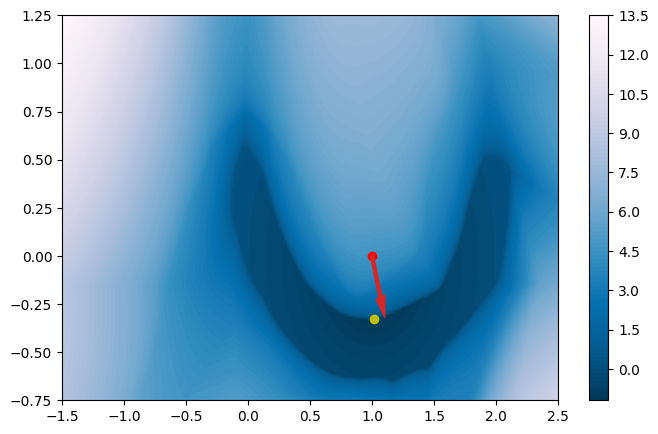

tensor([0.3379], grad_fn=<AddBackward0>) 0.3379290997982025 0.0 0.0
tensor(-1.1143)


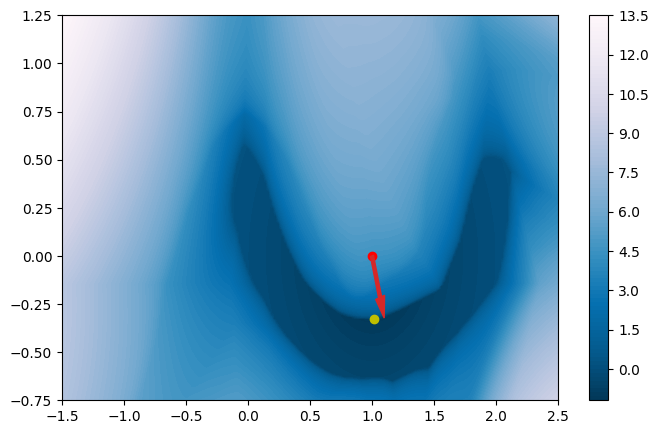

tensor([0.3423], grad_fn=<AddBackward0>) 0.34233206510543823 0.0 0.0
tensor(-1.1143)


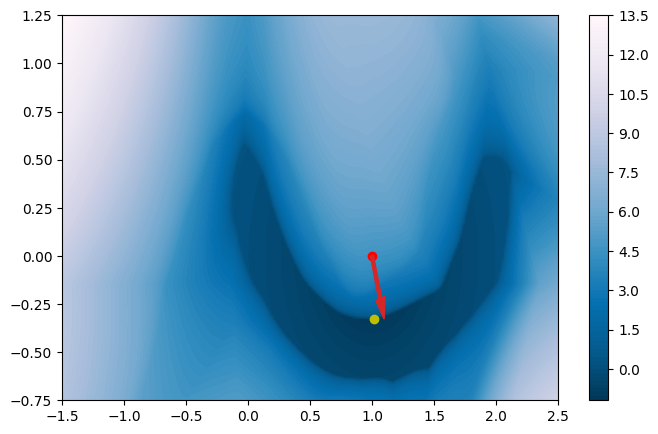

tensor([0.3361], grad_fn=<AddBackward0>) 0.3360883295536041 0.0 0.0
tensor(-1.1143)


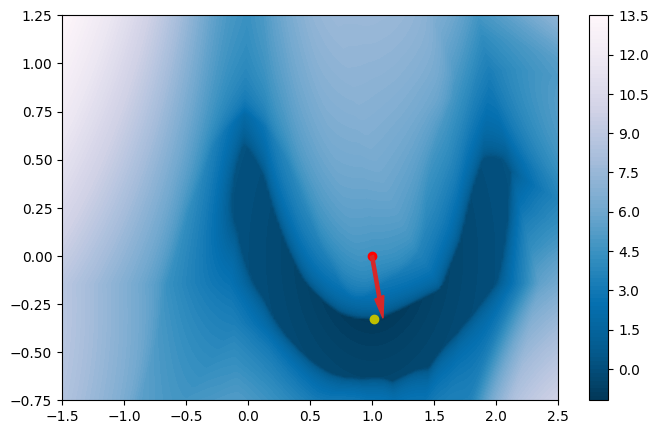

tensor([0.3453], grad_fn=<AddBackward0>) 0.34525689482688904 0.0 0.0
tensor(-1.1143)


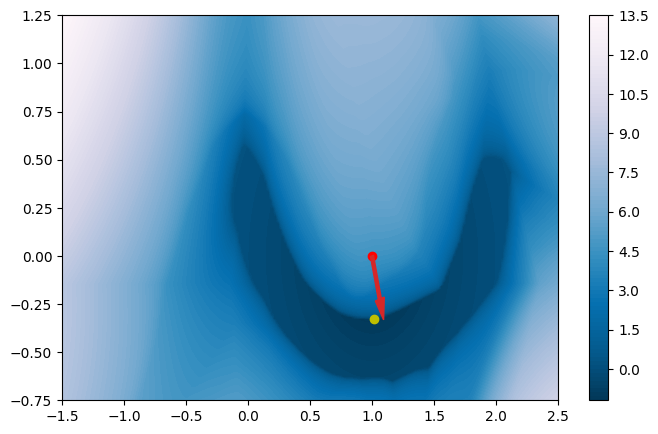

tensor([0.3343], grad_fn=<AddBackward0>) 0.3342927098274231 0.0 0.0
tensor(-1.1143)


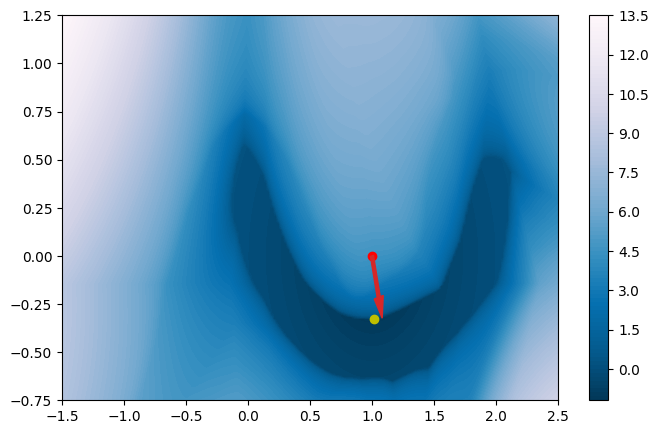

tensor([0.3466], grad_fn=<AddBackward0>) 0.3465995490550995 0.0 0.0
tensor(-1.1143)


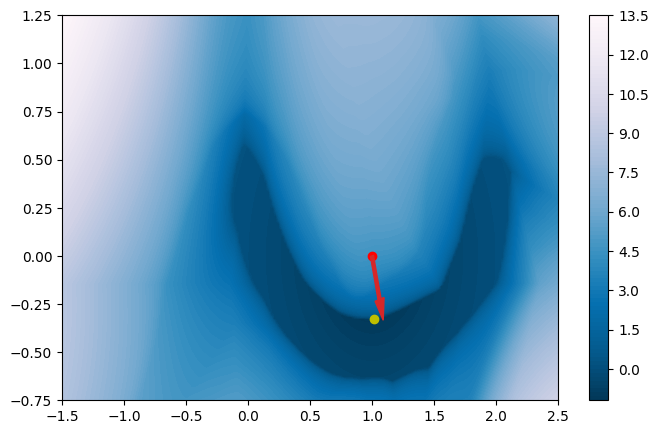

tensor([0.3324], grad_fn=<AddBackward0>) 0.332433819770813 0.0 0.0
tensor(-1.1143)


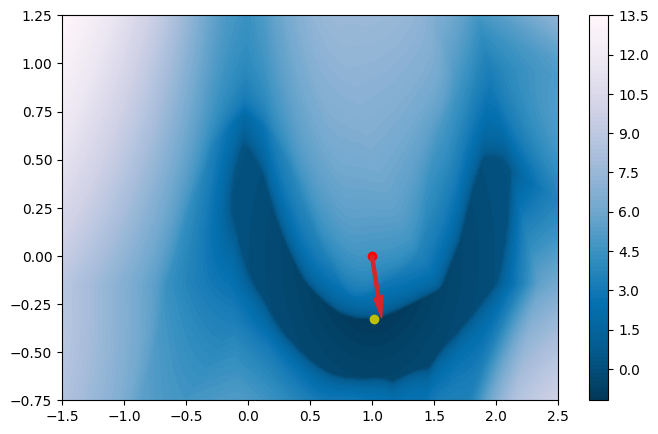

tensor([0.3472], grad_fn=<AddBackward0>) 0.34720972180366516 0.0 0.0
tensor(-1.1143)


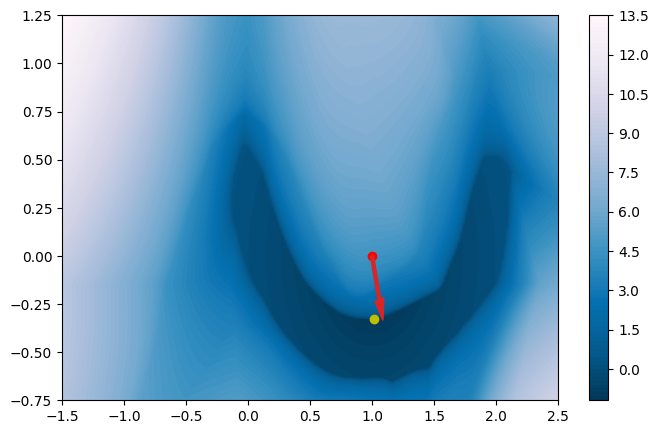

tensor([0.3302], grad_fn=<AddBackward0>) 0.3302151560783386 0.0 0.0
tensor(-1.1143)


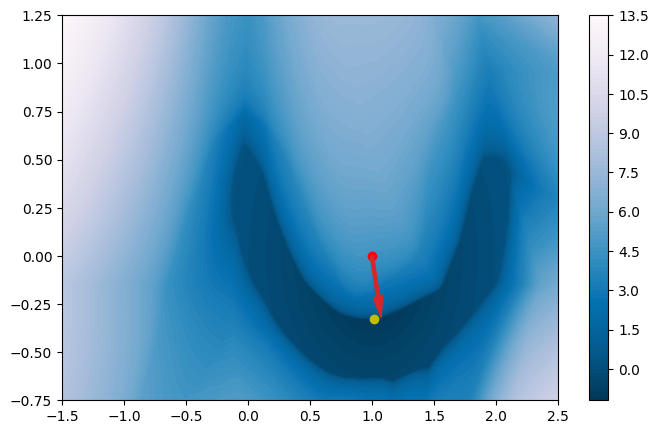

tensor([0.3529], grad_fn=<AddBackward0>) 0.35288408398628235 0.0 0.0
tensor(-1.1143)


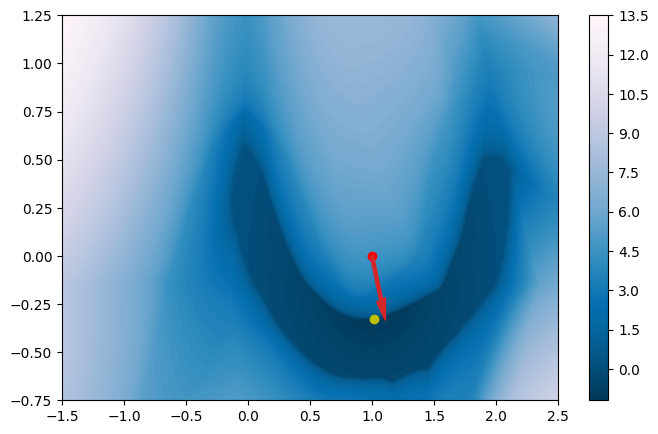

tensor([0.3318], grad_fn=<AddBackward0>) 0.33178219199180603 0.0 0.0
tensor(-1.1143)


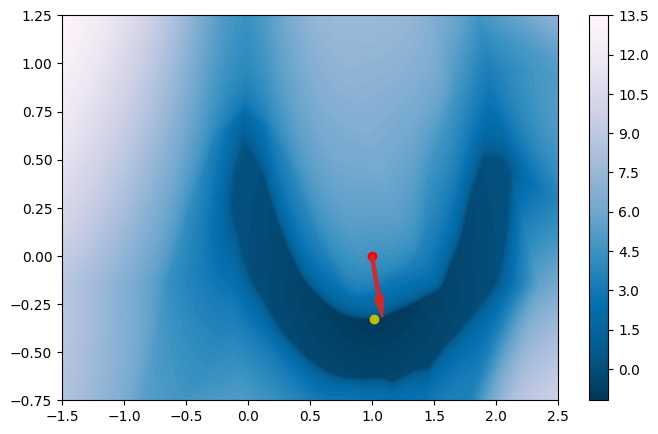

tensor([0.3499], grad_fn=<AddBackward0>) 0.34989580512046814 0.0 0.0
tensor(-1.1143)


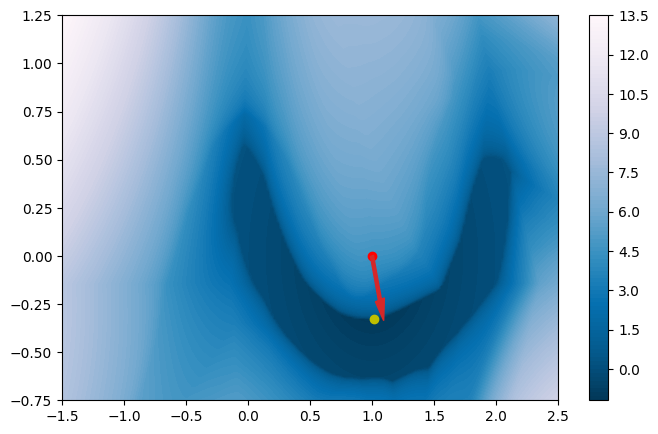

tensor([0.3481], grad_fn=<AddBackward0>) 0.32832643389701843 0.003951072692871094 0.0
tensor(-1.1143)


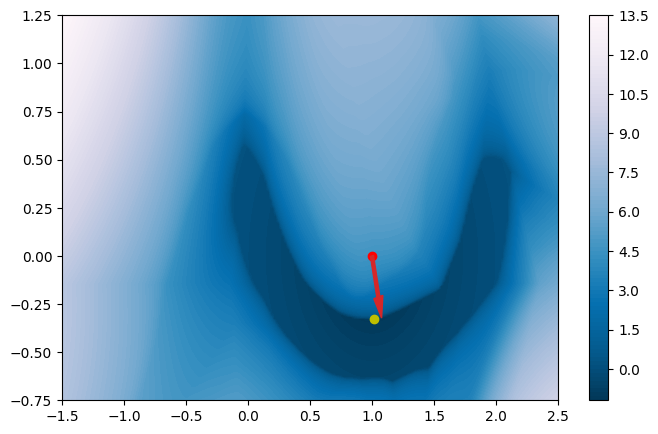

tensor([0.3486], grad_fn=<AddBackward0>) 0.348611056804657 0.0 0.0
tensor(-1.1143)


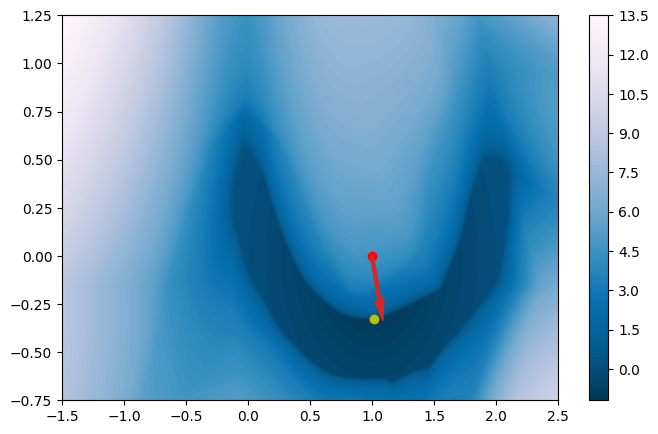

tensor([0.3302], grad_fn=<AddBackward0>) 0.3302374482154846 0.0 0.0
tensor(-1.1143)


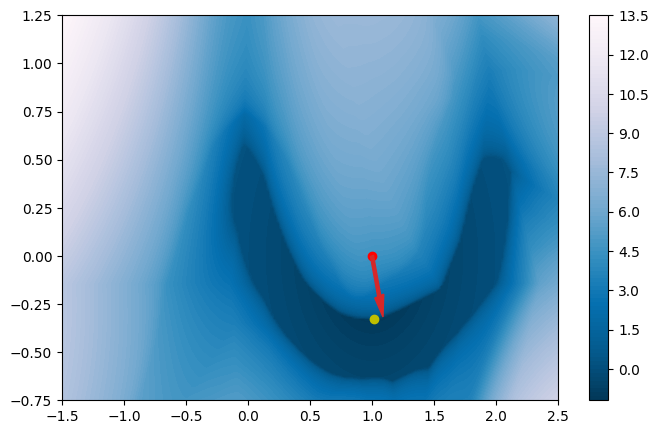

tensor([0.3516], grad_fn=<AddBackward0>) 0.3515987694263458 0.0 0.0
tensor(-1.1143)


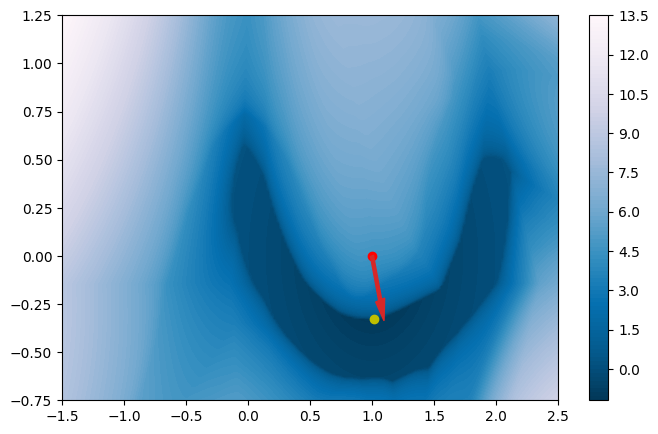

tensor([0.3397], grad_fn=<AddBackward0>) 0.33969008922576904 0.0 0.0
tensor(-1.1143)


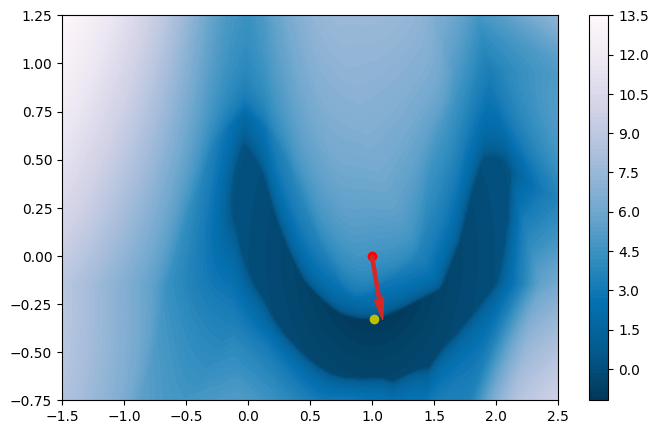

tensor([0.3575], grad_fn=<AddBackward0>) 0.3574756979942322 0.0 0.0
tensor(-1.1143)


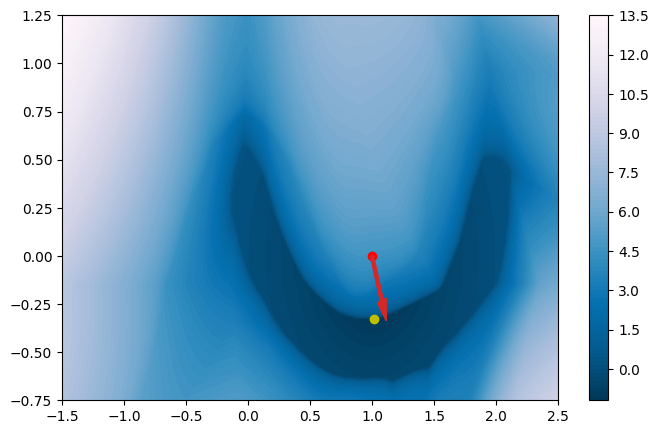

tensor([0.3376], grad_fn=<AddBackward0>) 0.33756014704704285 0.0 0.0
tensor(-1.1143)


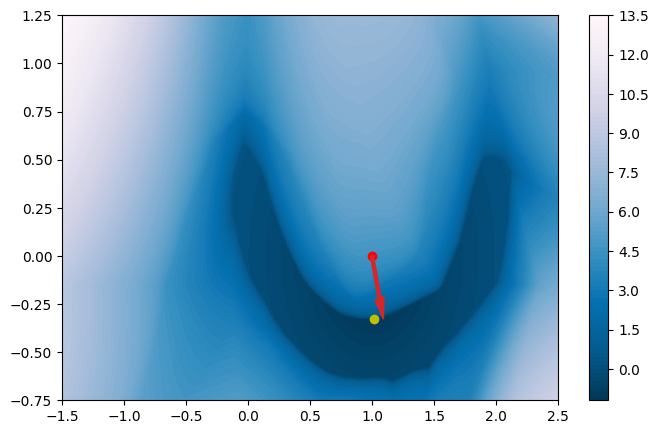

tensor([0.3520], grad_fn=<AddBackward0>) 0.3519652783870697 0.0 0.0
tensor(-1.1143)


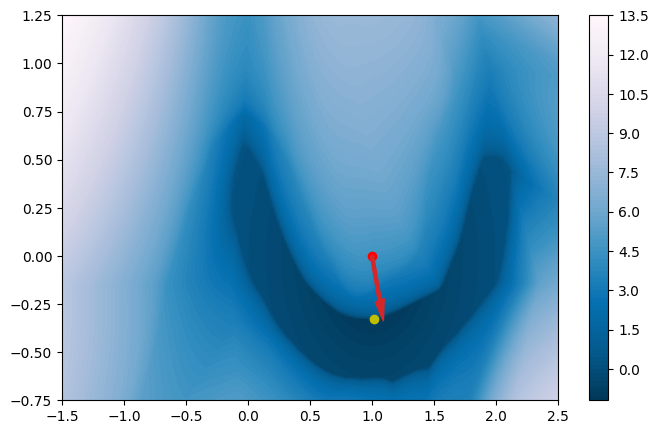

tensor([0.3579], grad_fn=<AddBackward0>) 0.35785430669784546 0.0 0.0
tensor(-1.1143)


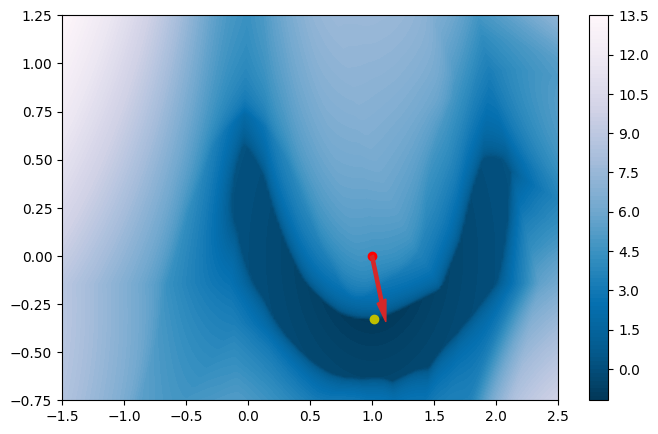

tensor([0.3555], grad_fn=<AddBackward0>) 0.35551247000694275 0.0 0.0
tensor(-1.1143)


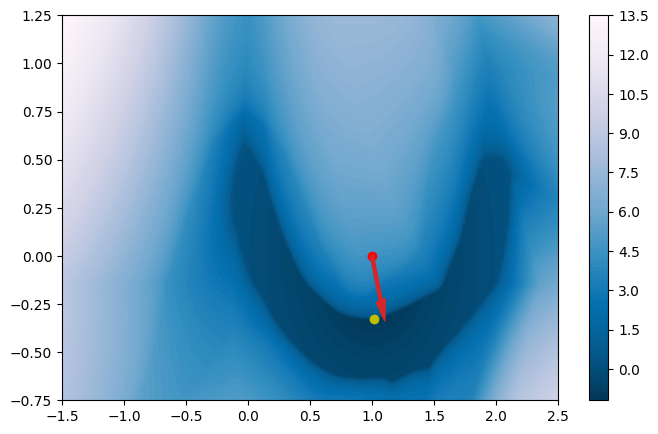

tensor([0.3522], grad_fn=<AddBackward0>) 0.3522004783153534 0.0 0.0
tensor(-1.1143)


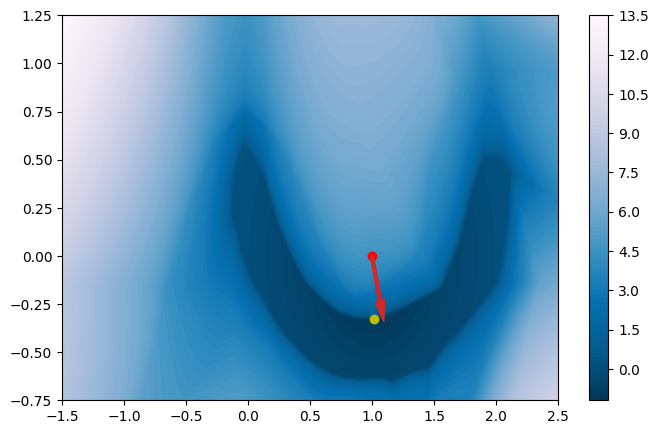

tensor([0.3604], grad_fn=<AddBackward0>) 0.3604140281677246 0.0 0.0
tensor(-1.1143)


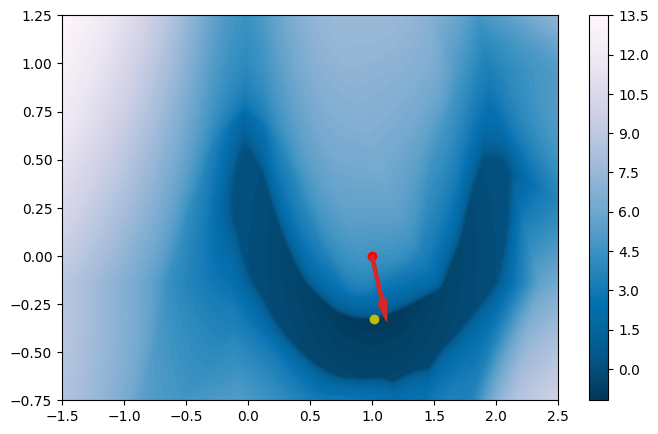

tensor([0.3510], grad_fn=<AddBackward0>) 0.3509994149208069 0.0 0.0
tensor(-1.1143)


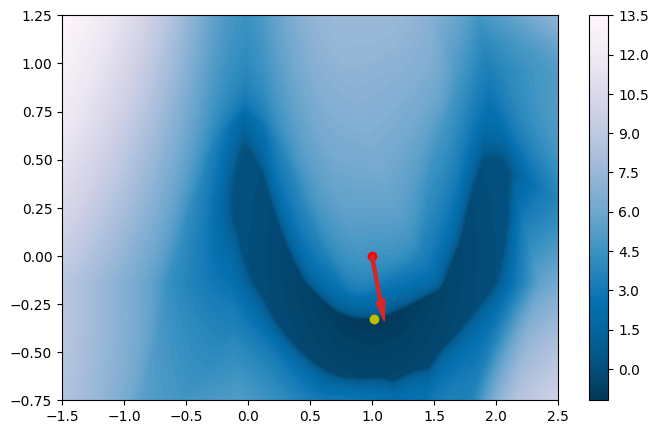

tensor([0.3534], grad_fn=<AddBackward0>) 0.35339799523353577 0.0 0.0
tensor(-1.1143)


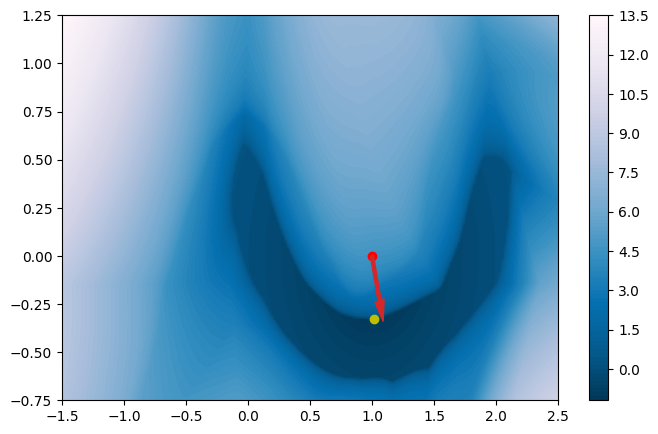

tensor([0.3441], grad_fn=<AddBackward0>) 0.3441070318222046 0.0 0.0
tensor(-1.1143)


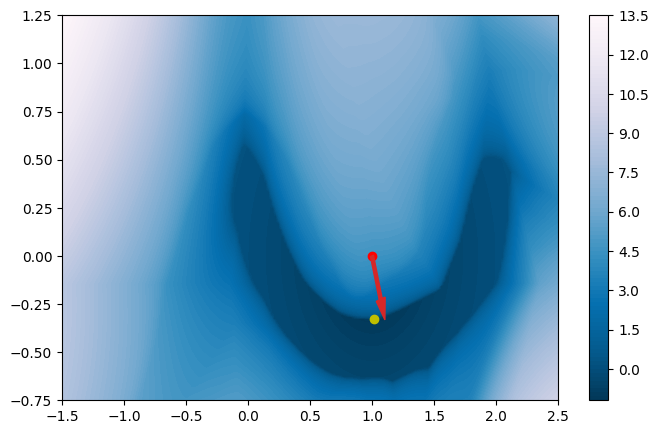

tensor([0.3559], grad_fn=<AddBackward0>) 0.3559171259403229 0.0 0.0
tensor(-1.1143)


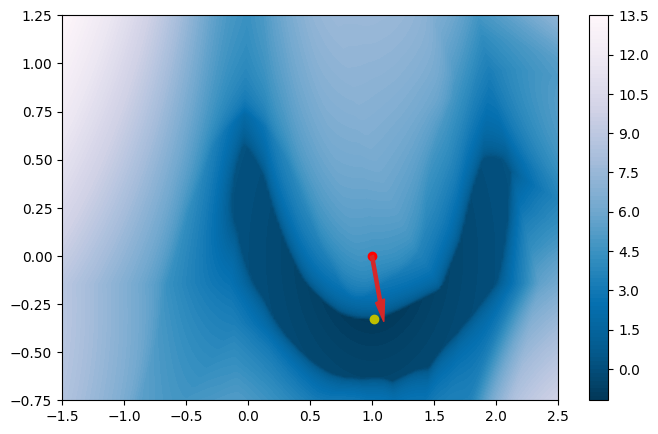

tensor([0.3701], grad_fn=<AddBackward0>) 0.3700755834579468 0.0 0.0
tensor(-1.1143)


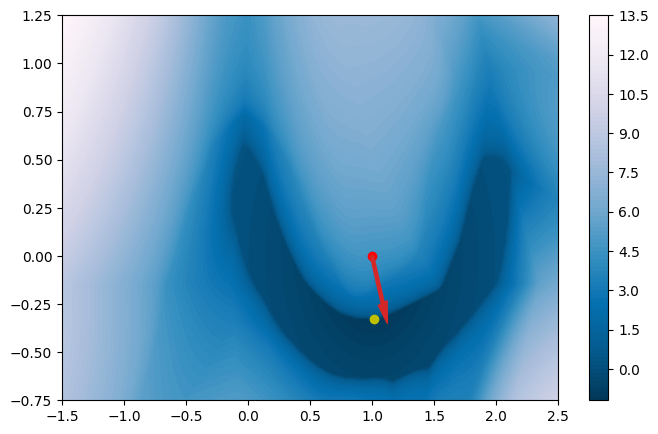

tensor([0.3590], grad_fn=<AddBackward0>) 0.35899269580841064 0.0 0.0
tensor(-1.1143)


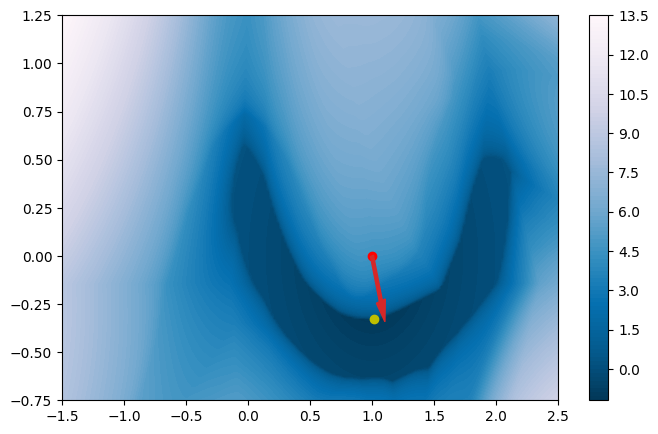

tensor([0.3623], grad_fn=<AddBackward0>) 0.36226212978363037 0.0 0.0
tensor(-1.1143)


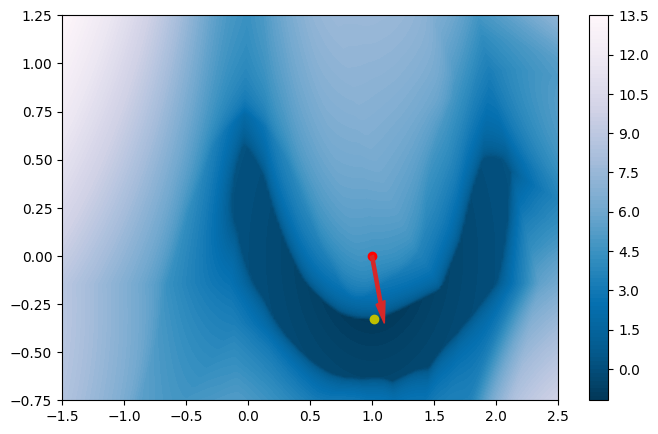

tensor([0.3638], grad_fn=<AddBackward0>) 0.36378780007362366 0.0 0.0
tensor(-1.1143)


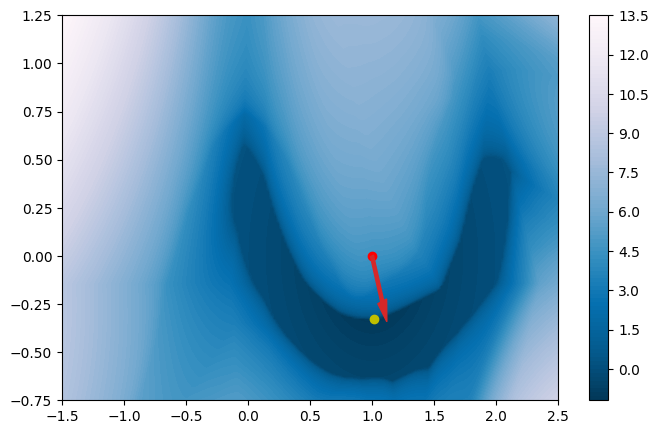

tensor([0.3614], grad_fn=<AddBackward0>) 0.36144667863845825 0.0 0.0
tensor(-1.1143)


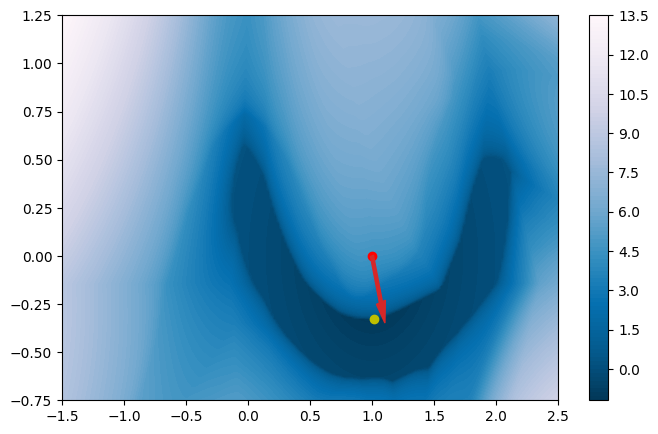

tensor([0.3659], grad_fn=<AddBackward0>) 0.36590543389320374 0.0 0.0
tensor(-1.1143)


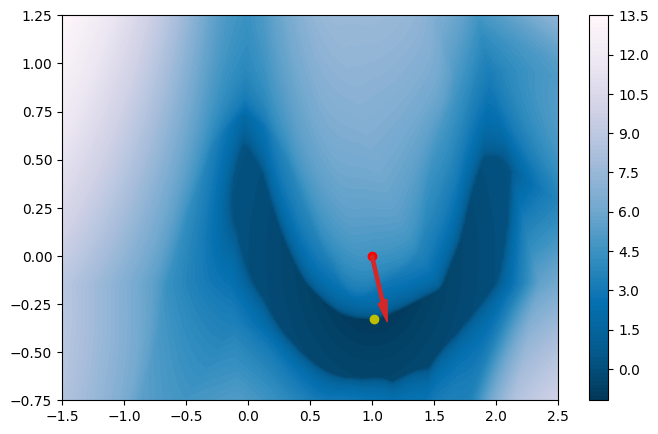

tensor([0.3586], grad_fn=<AddBackward0>) 0.3586394488811493 0.0 0.0
tensor(-1.1143)


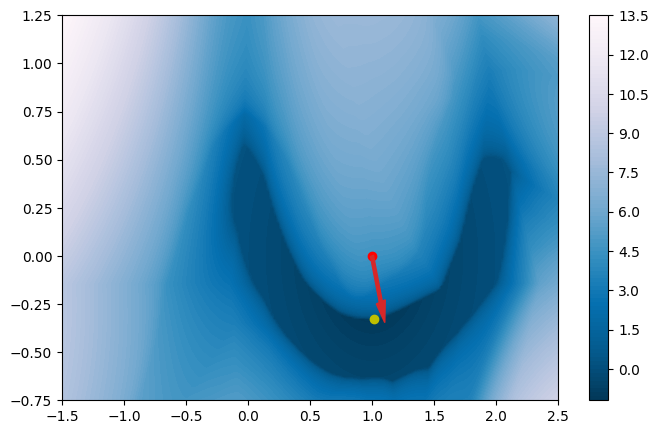

tensor([0.3570], grad_fn=<AddBackward0>) 0.3570168614387512 0.0 0.0
tensor(-1.1143)


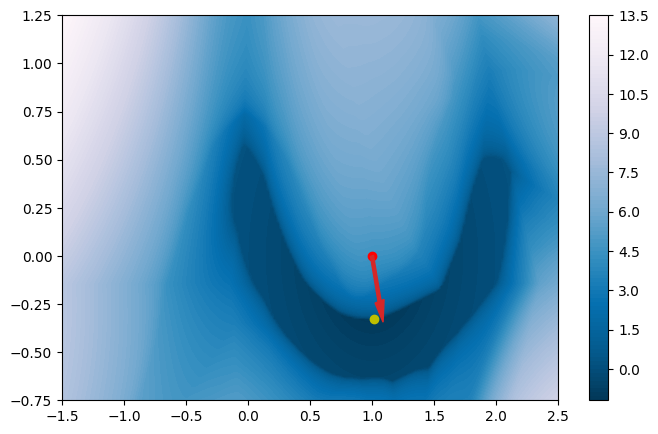

In [66]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)
optimizer = torch.optim.Adam([x], lr=0.01)
alpha = 5

num_iterations = 5000
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1])

for i in range(num_iterations):
    y, dist, max_inner, max_outer = cf.search_step(x_param=x, x_origin=x_origin, context_origin=context_origin, context_target=context_target, alpha=alpha, beta=0.01)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        print(y, dist.detach().item(), max_inner.detach().item(), max_outer.detach().item())
        plot_loss_space(x, x_origin, cf.search_step, alpha=alpha, beta=0.01)

In [27]:
import matplotlib.pyplot as plt